# Neural Network Classifier (12 marks)

In [1]:
#Import Libraries

import os
import numpy as np
import pandas as pd  # use pandas to load data from CSV files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the data

data_path = "activity_recognition_dataset/S1_Dataset"
files = os.listdir(data_path)

combined_data = []

for file in files:    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file (Dataframe)
        # The CSV files have columns without a header, so header=None is used
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an EXTRA COLUMN equal to the filename
        seq_dataframe['seqID'] = file  # use filename as ID
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [3]:
# Formatting the data

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0

In [4]:
# Splitting the data and making it usable for i.i.d classifier

X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=190)  # You may wish to make further splits of the data or to modify this split.

X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier


In [5]:
# Train a Neural Network

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_test = scaler.fit_transform(X_test)

# print (f'train_x\'s min: {X_tr.min()}')
# print (f'train_x\'s max: {X_test.max()}')

# print(np.mean(X_tr, axis=0))
# print(np.var(X_tr, axis = 0))

mlp =  MLPClassifier(max_iter=500)
mlp.fit(X_tr, y_tr)

training_accuracy = mlp.score(X_tr, y_tr)
print("Training accuracy:", training_accuracy)

testing_accuracy = mlp.score(X_test, y_test)
print("Testing accuracy:", testing_accuracy)

Training accuracy: 0.9528114265051528
Testing accuracy: 0.901053396294951


In [6]:
# Training and validation curves
train_sizes, train_scores, val_scores = learning_curve(mlp, X_tr, y_tr, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 10))

# print(train_sizes)
# print(train_scores)
# print(val_scores)

[0.99741602 0.99795501 0.98646676 0.97489079 0.97612077 0.9709423
 0.96285588 0.96306047 0.9649413  0.95687885]
[0.56698495 0.79817734 0.79939007 0.83684125 0.8507101  0.89722848
 0.90329807 0.90841222 0.90980713 0.9055196 ]


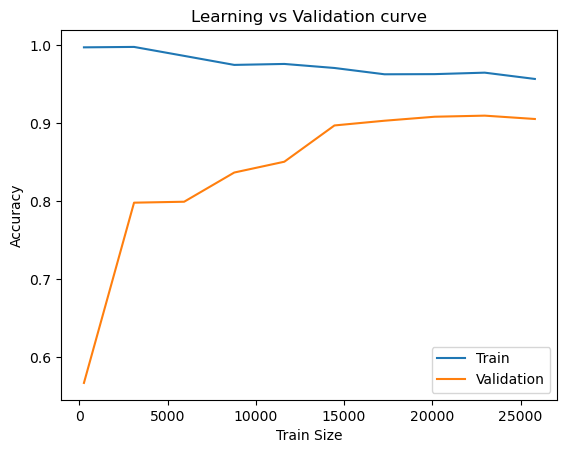

In [7]:
train_mean = np.mean(train_scores, axis = 1)
validation_mean = np.mean(val_scores, axis=1)

print(train_mean)
print(validation_mean)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, validation_mean, label="Validation")
plt.title("Learning vs Validation curve")
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
# Testing hyperparameters:
'''
Hyperparameters to tune:
max_iter: yes
hidden_layer_sizes: yes
solver: yes
alpha: yes
learning_rate: maybe
learning_rate_init: yes
max_iter: maybe
n_iter_no_change: maybe
'''

'\nHyperparameters to tune:\nmax_iter: yes\nhidden_layer_sizes: yes\nsolver: yes\nalpha: yes\nlearning_rate: maybe\nlearning_rate_init: yes\nmax_iter: maybe\nn_iter_no_change: maybe\n'

## Evaluating max_iter

In [9]:
# max_iter:

# define the parameter grid for max_iter
param_grid = {'max_iter': np.arange(250, 1001, 250)}

# Create an MLP classifier
mlp = MLPClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
max_iters = param_grid['max_iter']

C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


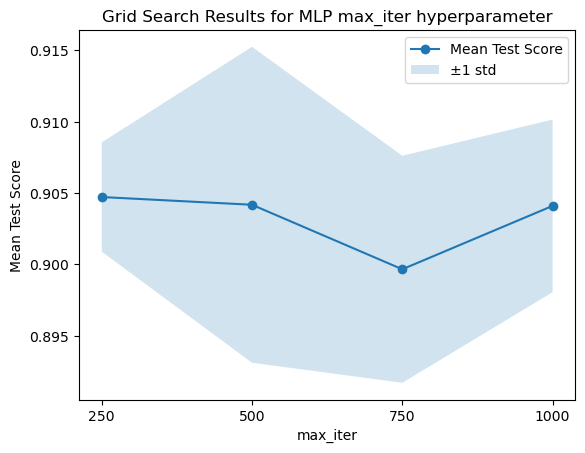

In [10]:
# Plot the results

x_values = range(len(max_iters))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, max_iters)
plt.xticks(x_values, max_iters)
plt.title("Grid Search Results for MLP max_iter hyperparameter")
plt.xlabel("max_iter")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Evaluating alpha

In [11]:
# alpha:

# Define the parameter grid for alpha
param_grid = {'alpha': np.append(0, np.logspace(-5, 1, 7))}

# Create an MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
alphas = param_grid['alpha']


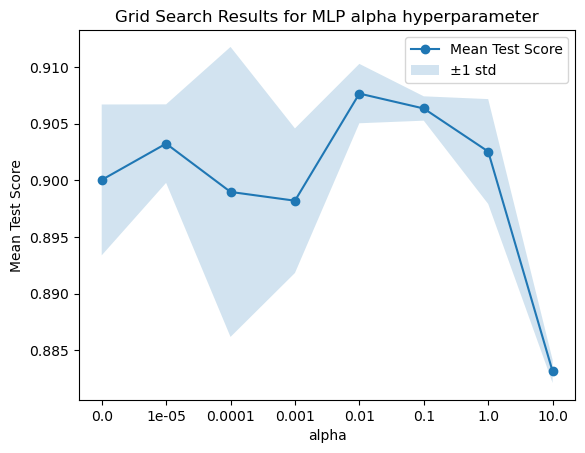

In [12]:
# Plot the results

x_values = range(len(alphas))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, alphas)
plt.title("Grid Search Results for MLP alpha hyperparameter")
plt.xlabel("alpha")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()


## Evaluating hidden_layer_sizes

In [13]:
# hidden_layer_sizes:

# Define the parameter grid for hidden_layer_sizes
param_grid = {'hidden_layer_sizes': [(32,), (64,), (128,), (256,), (512,)]}

# Create an MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
hidden_layer_sizes = param_grid['hidden_layer_sizes']

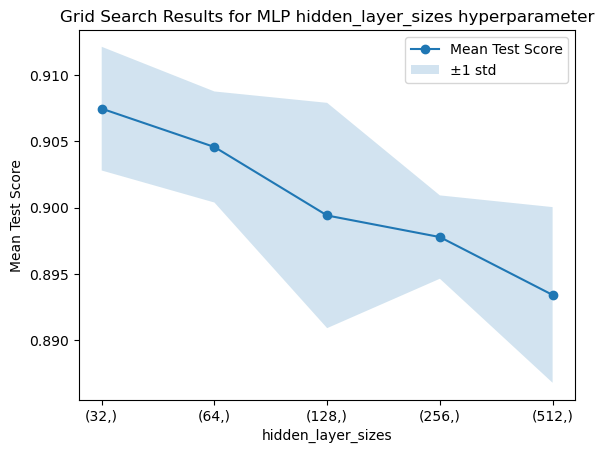

In [14]:
# Plot the results

x_values = range(len(hidden_layer_sizes))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, hidden_layer_sizes)
plt.title("Grid Search Results for MLP hidden_layer_sizes hyperparameter")
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Evaluating solver

In [15]:
# hidden_layer_sizes:

# Define the parameter grid for solvers
param_grid = {'solver': ['lbfgs', 'sgd', 'adam']}

# Create an MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
solvers = param_grid['solver']

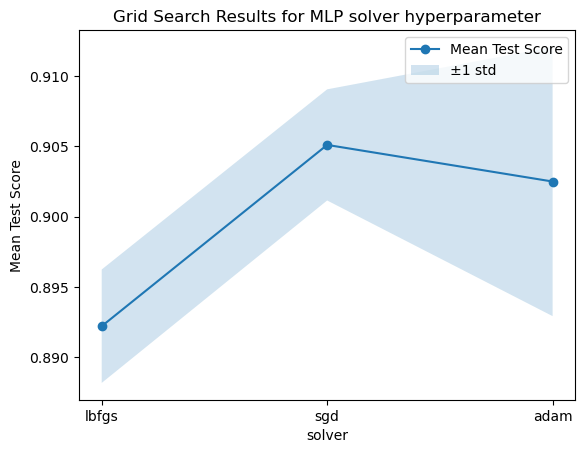

In [16]:
# Plot the results

x_values = range(len(solvers))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, solvers)
plt.title("Grid Search Results for MLP solver hyperparameter")
plt.xlabel("solver")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Evaluating learning_rate_init

In [17]:
# learning_rate_init:

# Define the parameter grid for learning_rate_init
param_grid = {'learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

# Create an MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
learning_rate_init = param_grid['learning_rate_init']

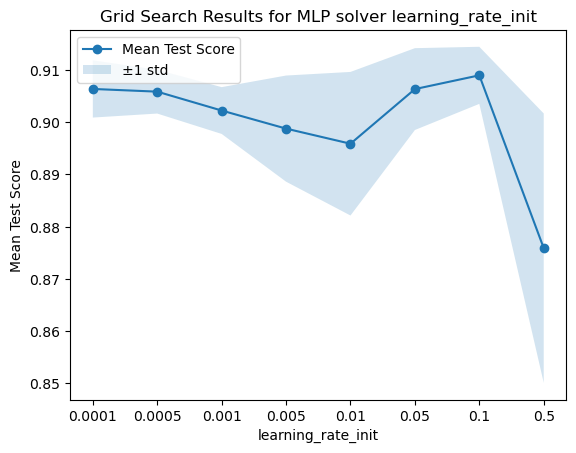

In [18]:
# Plot the results

x_values = range(len(learning_rate_init))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')
plt.xticks(x_values, learning_rate_init)
plt.title("Grid Search Results for MLP solver learning_rate_init")
plt.xlabel("learning_rate_init")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Testing and Training performance

[0.9518816023968799, 0.9492471007567735, 0.953095539427125, 0.9472066534080636, 0.9469225404860914, 0.9337242038381073, 0.9044347444275125, 0.883152103727045]
[0.8936432982201234, 0.8897203051216854, 0.9015619324373411, 0.8936432982201234, 0.9098438067562659, 0.9246640029059208, 0.88492553577915, 0.837486378496186]


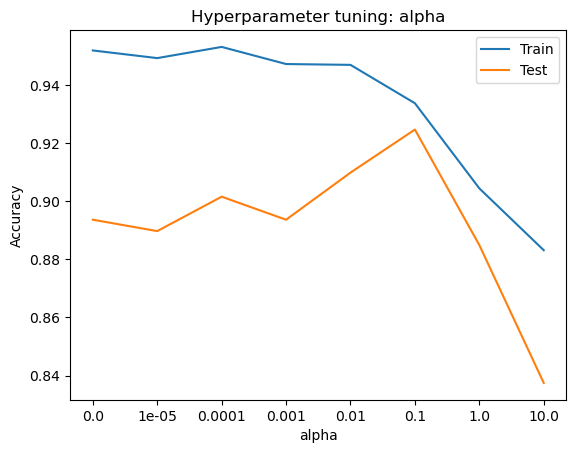

In [19]:
# Tuning alpha:

# array of values for alpha ranging from 0 to 10
alphas = np.append(0, np.logspace(-5, 1, 7))
train_accuracies = []
test_accuracies = []

# training_accuracy = mlp.score(X_tr, y_tr)
# print("Training accuracy:", training_accuracy)

# testing_accuracy = mlp.score(X_test, y_test)
# print("Testing accuracy:", testing_accuracy)

for alpha in alphas:
    mlp = MLPClassifier(max_iter=500, alpha=alpha)
    mlp.fit(X_tr, y_tr)
    train_acc = mlp.score(X_tr, y_tr)
    test_acc = mlp.score(X_test, y_test)
    # print("Training accuracy for alpha =", alpha, ":", train_acc)
    # print("Test accuracy for alpha =", alpha, ":", test_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print(train_accuracies)
print(test_accuracies)

x_values = range(len(alphas))
plt.plot(x_values, train_accuracies, label="Train")
plt.plot(x_values, test_accuracies, label="Test")

plt.xticks(x_values, alphas)
plt.title("Hyperparameter tuning: alpha")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.9359454503189814, 0.94537283363897, 0.9536637652710696, 0.9669395872614097, 0.9701423147454606]
[0.9108608790410462, 0.9057755176171449, 0.8974936432982201, 0.8935706501997821, 0.8973483472575372]


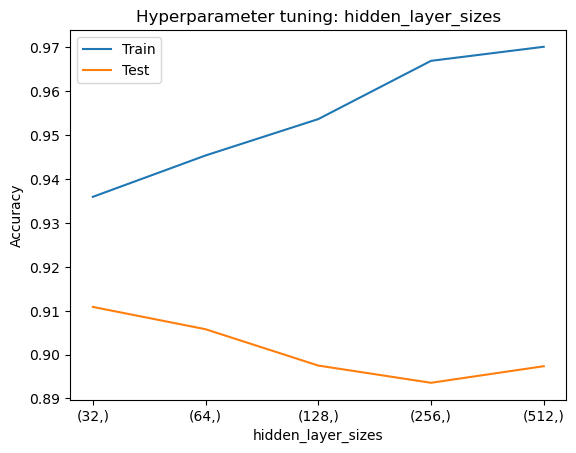

In [20]:
# Tuning hidden_layer_sizes:

# array of hidden layer sizes ranging from 32 to 512
layer_sizes = [(32,), (64,), (128,), (256,), (512,)]
train_accuracies = []
test_accuracies = []

for layers in layer_sizes:
    mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=layers)
    mlp.fit(X_tr, y_tr)
    train_acc = mlp.score(X_tr, y_tr)
    test_acc = mlp.score(X_test, y_test)
    # print("Training accuracy for hidden_layer_sizes =", layers, ":", train_acc)
    # print("Test accuracy for hidden_layer_sizes =", layers, ":", test_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print(train_accuracies)
print(test_accuracies)

x_values = range(len(layer_sizes))
plt.plot(x_values, train_accuracies, label="Train")
plt.plot(x_values, test_accuracies, label="Test")

plt.xticks(x_values, layer_sizes)
plt.title("Hyperparameter tuning: hidden_layer_sizes")
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[0.9557558695146835, 0.9297724513779476, 0.9517008032647157]
[0.8781692698873955, 0.9231383944787505, 0.9030875408645115]


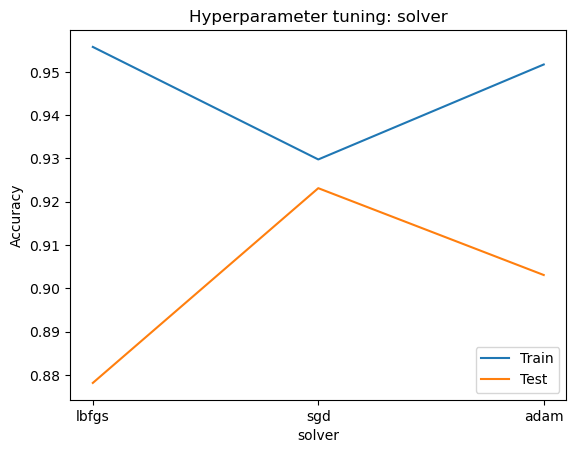

In [21]:
# Tuning solver:

# array of all possible solver for weight optimization.
solvers = ["lbfgs", "sgd", "adam"]
train_accuracies = []
test_accuracies = []

for solver in solvers:
    mlp = MLPClassifier(max_iter=500, solver=solver)
    mlp.fit(X_tr, y_tr)
    train_acc = mlp.score(X_tr, y_tr)
    test_acc = mlp.score(X_test, y_test)
    # print("Training accuracy for solver =", solver, ":", train_acc)
    # print("Test accuracy for solver =", solver, ":", test_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print(train_accuracies)
print(test_accuracies)

x_values = range(len(solvers))
plt.plot(x_values, train_accuracies, label="Train")
plt.plot(x_values, test_accuracies, label="Test")

plt.xticks(x_values, solvers)
plt.title("Hyperparameter tuning: solver")
plt.xlabel("solver")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\parim\anaconda3\envs\ml-cw\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.9045122297698686, 0.9332592917839708, 0.9453470051915179, 0.9500994395226903, 0.9224113438541209]
[0.8915365056302216, 0.9193606974209952, 0.9022884126407555, 0.8796222302942245, 0.9205957137667998]


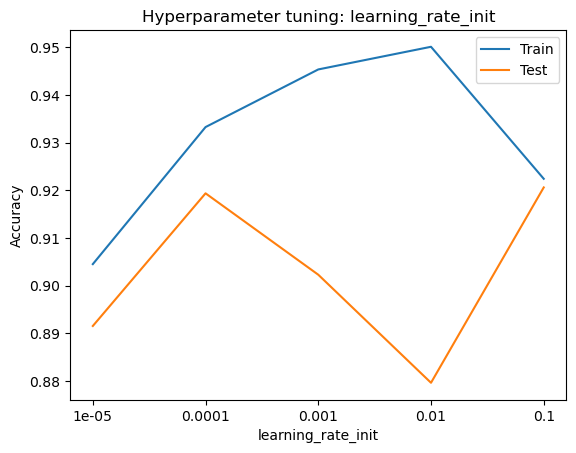

In [22]:
# Tuning learning_rate_init:

# array of a range of learning_rates ranging from 1e-05 to 1e-01
learning_rates = np.logspace(-5, -1, 5)
train_accuracies = []
test_accuracies = []

for lr in learning_rates:
    mlp = MLPClassifier(learning_rate_init=lr)
    mlp.fit(X_tr, y_tr)
    train_acc = mlp.score(X_tr, y_tr)
    test_acc = mlp.score(X_test, y_test)
    # print("Training accuracy for learning_rate_init =", lr, ":", train_acc)
    # print("Test accuracy for learning_rate_init =", lr, ":", test_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print(train_accuracies)
print(test_accuracies)

x_values = range(len(learning_rates))
plt.plot(x_values, train_accuracies, label="Train")
plt.plot(x_values, test_accuracies, label="Test")

plt.xticks(x_values, learning_rates)
plt.title("Hyperparameter tuning: learning_rate_init")
plt.xlabel("learning_rate_init")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
# Best combination of hyperparameters for all values
# Define the parameter grid for alpha
param_grid = {'solver': ['sgd', 'adam'],
              'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
              'learning_rate_init': [0.001, 0.005, 0.01, 0.05, 0.1],
              'hidden_layer_sizes': [(32,), (64,), (100,)]
             }

# Create an MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Print the best hyperparameters
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Best Hyperparameters: {'alpha': 0.05, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'solver': 'adam'}
Test Accuracy with Best Hyperparameters: 0.9088267344714857
